# Hyperparameter Tuning via Scikit-Learn

## Hyper Band

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# StatsModel
import scipy
from scipy.stats import randint,truncnorm

# Scikit-Learn
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [3]:
# HyperBand
from hyperband import HyperbandSearchCV

### Loading Data

In [4]:
df = pd.read_csv("/Users/joaquinromero/Desktop/HPTP/data/train.csv", sep=";")

In [5]:
df['y'] = df['y'].map({'yes':1,'no':0})

### Train/Test Split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

#### Placing Numerical Features

In [7]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

#### Placing Categorical Features

In [8]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

### Pre-Processor

In [9]:
# Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

### Pipeline

In [11]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

In [12]:
#### Placing All Features for Training Set

In [13]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


In [14]:
#### Placing All Features for Test Set

In [15]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


#### Calculating F1-Score on Test Data without Hyperparameter Tuning

In [16]:
# Fitting The Pipeline on Train Data 
pipe.fit(X_train_full,y_train)

# Evaluating on the Test Data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5035971223021583


#### Defining The Hyperparameter Space

In [17]:
hyperparameter_space = {
"model__criterion": ["gini", "entropy"],
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": truncnorm(a=0,b=0.5,loc=0.005, scale=0.01),
} 

### Performing `HyperbandSearchCV`

In [18]:
clf = HyperbandSearchCV(pipe, hyperparameter_space,
                        resource_param='model__n_estimators',
                        eta=3,min_iter=1,max_iter=100,
                        random_state = 0,
                        scoring = 'f1', cv=5, 
                        n_jobs=-1, refit = True,
                        verbose=2)

#### Running it

In [19]:
clf.fit(X_train_full, y_train)

Starting bracket 1 (out of 5) of hyperband
Starting successive halving iteration 1 out of 5. Fitting 81 configurations, with resource_param model__n_estimators set to 1, and keeping the best 27 configurations.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting successive halving iteration 2 out of 5. Fitting 27 configurations, with resource_param model__n_estimators set to 3, and keeping the best 9 configurations.
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Starting successive halving iteration 3 out of 5. Fitting 9 configurations, with resource_param model__n_estimators set to 11, and keeping the best 3 configurations.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Starting successive halving iteration 4 out of 5. Fitting 3 configurations, with resource_param model__n_estimators set to 33, and keeping the best 1 configurations.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Starting successive halving iteration 5 out of 5

HyperbandSearchCV(cv=5,
                  estimator=Pipeline(steps=[('preprocessor',
                                             ColumnTransformer(transformers=[('num',
                                                                              StandardScaler(),
                                                                              ['age',
                                                                               'balance',
                                                                               'day',
                                                                               'duration',
                                                                               'campaign',
                                                                               'pdays',
                                                                               'previous']),
                                                                             ('cat',
                                                                              OneHotEncoder(handle_unknown='ignore'),
                                                                              ['job',
                                                                               'marital',
                                                                               'education',
                                                                               'default',
                                                                               'housing',
                                                                               'loan',
                                                                               'contact',
                                                                               'month',
                                                                               'poutcome'])])),
                                            ('model',
                                             RandomForestClassifier(random_state=0))]),
                  max_iter=100, n_jobs=-1,
                  param_distributions={'model__class_weight': ['balanced',
                                                               'balanced_subsample'],
                                       'model__criterion': ['gini', 'entropy'],
                                       'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x176d1f010>},
                  random_state=0, resource_param='model__n_estimators',
                  scoring='f1', verbose=2)

In [20]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__criterion': 'gini',
  'model__min_samples_split': np.float64(0.005466182311285862),
  'model__n_estimators': 100},
 np.float64(0.5603357686118083))

In [21]:
clf.score(X_test_full,y_test)

0.5623880597014925

In [22]:
def del_key(dict_,key):
    del dict_[key]
    return dict_

In [23]:
#delete model__n_estimators from params
results = pd.DataFrame(clf.cv_results_)
results['params'] = results['params'].apply(lambda x: del_key(x,'model__n_estimators'))

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005022534793470863)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005096502682891998)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005577173905818143)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.006436456848526467)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.006754499672946755)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007113046265838076)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007429677252603325)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007566189383136189)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007766131793967021)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007998561260633823)}",...,"{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008188066613355166)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008259899856330122)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008276239041798025)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008332918182480026)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008387309876201081)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008508505640352257)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008805642344802708)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009108682970315222)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.00929481441596796)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009619051711474445)}"
SH_iter,,,,,,,,,,,,,,,,,,,,,
0,0.475406,0.470009,0.472754,0.476851,0.465611,0.465694,0.459603,0.456367,0.462497,0.467737,...,0.473879,0.472255,0.47259,0.469706,0.468681,0.459842,0.476738,0.472393,0.467226,0.462654
1,0.525144,NaN,NaN,0.526648,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.522398,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


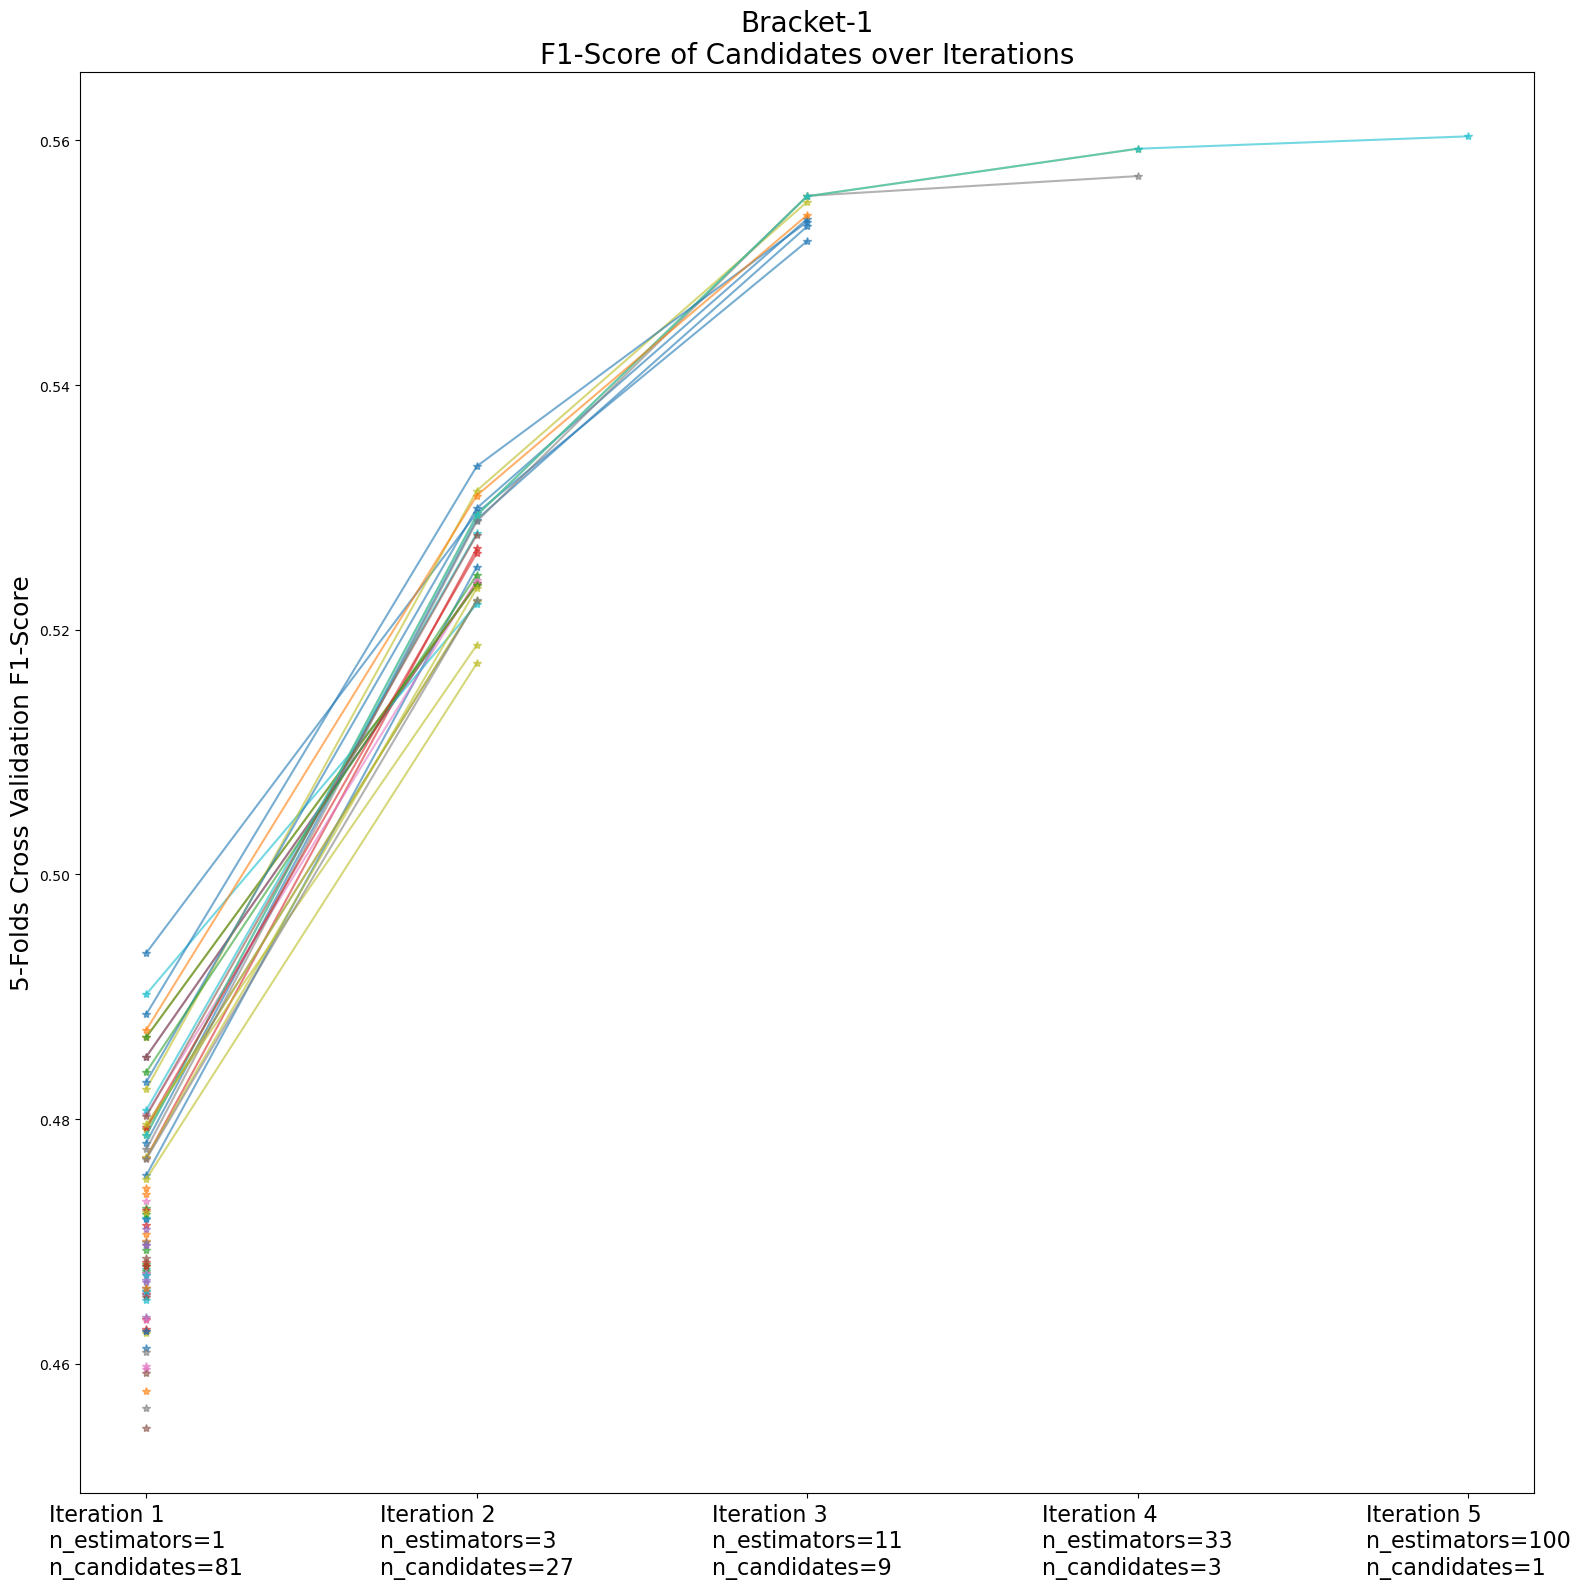

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.0050888919332800755)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005152808999026512)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.008028286725485497)}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.008406690731277092)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005260811274899587)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.006144199376846191)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008723961597705653)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009285639092110484)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005529966114173289)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.005824627744984233)}",...,"{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005774939985804109)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.006008801525696765)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.0060428303696995495)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.006076748047781741)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.0062671332468036455)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.007100213018754234)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.0071949025403375295)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.007870046392599797)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009445538366843987)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009612565661406343)}"
SH_iter,,,,,,,,,,,,,,,,,,,,,
0,0.529942,0.529465,0.522498,0.51859,0.529064,0.529613,0.516202,0.516467,NaN,0.53064,...,NaN,0.528191,0.526791,0.524776,0.526279,0.518743,0.52285,0.52088,0.514134,0.515175
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.554981,NaN,...,0.553894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


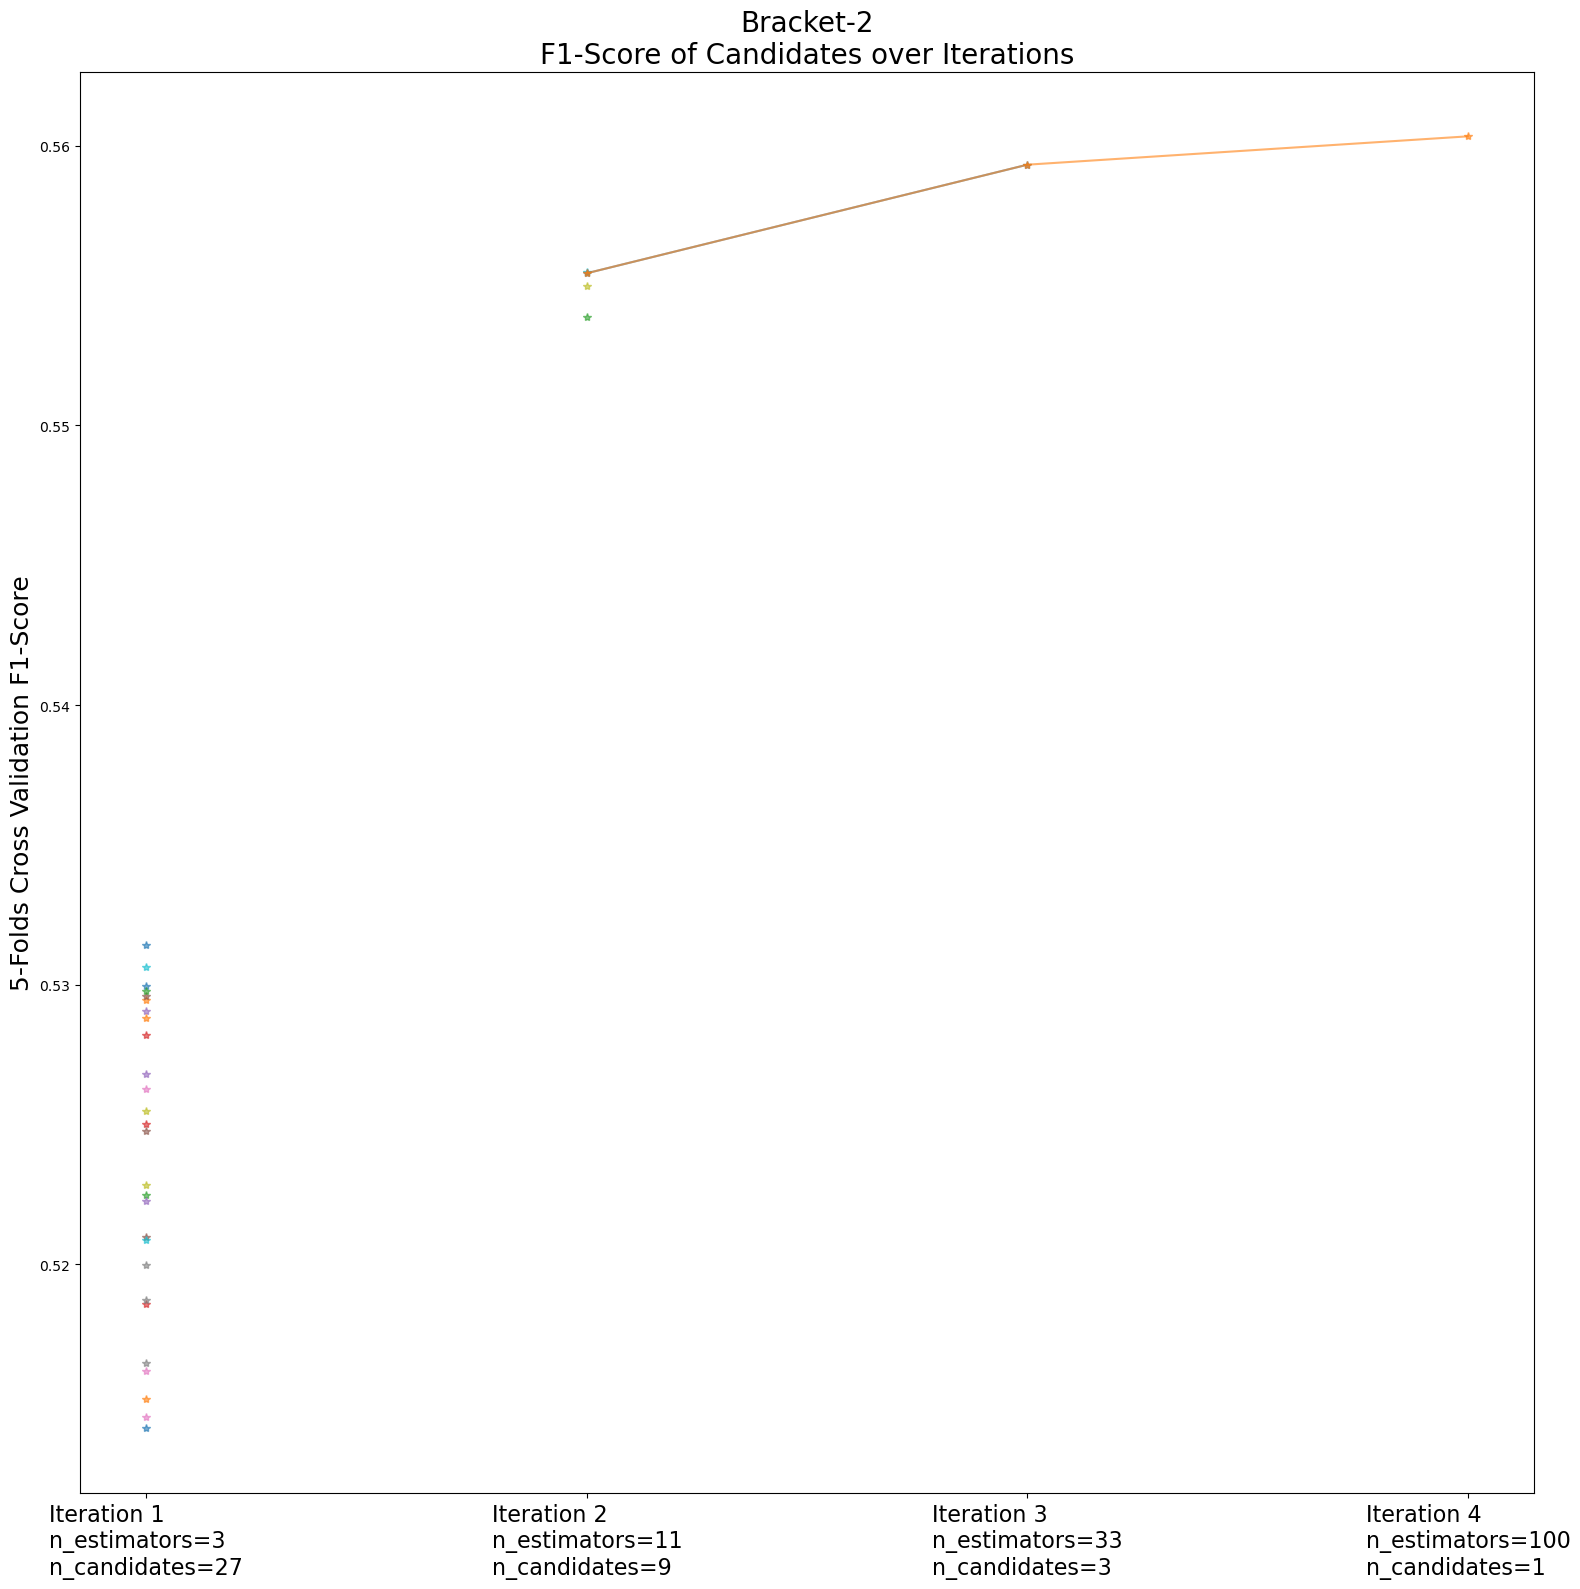

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.006036126613642239)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005123164969684294)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.006025532759934312)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.006850853169371982)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.008928801841646686)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.009100478666844372)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005466182311285862)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.008582755724280244)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009318639251244093)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.009744874735171029)}"
SH_iter,,,,,,,,,,
0,0.554427,0.556474,0.553462,0.550811,0.545948,0.542135,NaN,0.542801,0.541499,0.539719
1,NaN,NaN,NaN,NaN,NaN,NaN,0.559322,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.560336,NaN,NaN,NaN


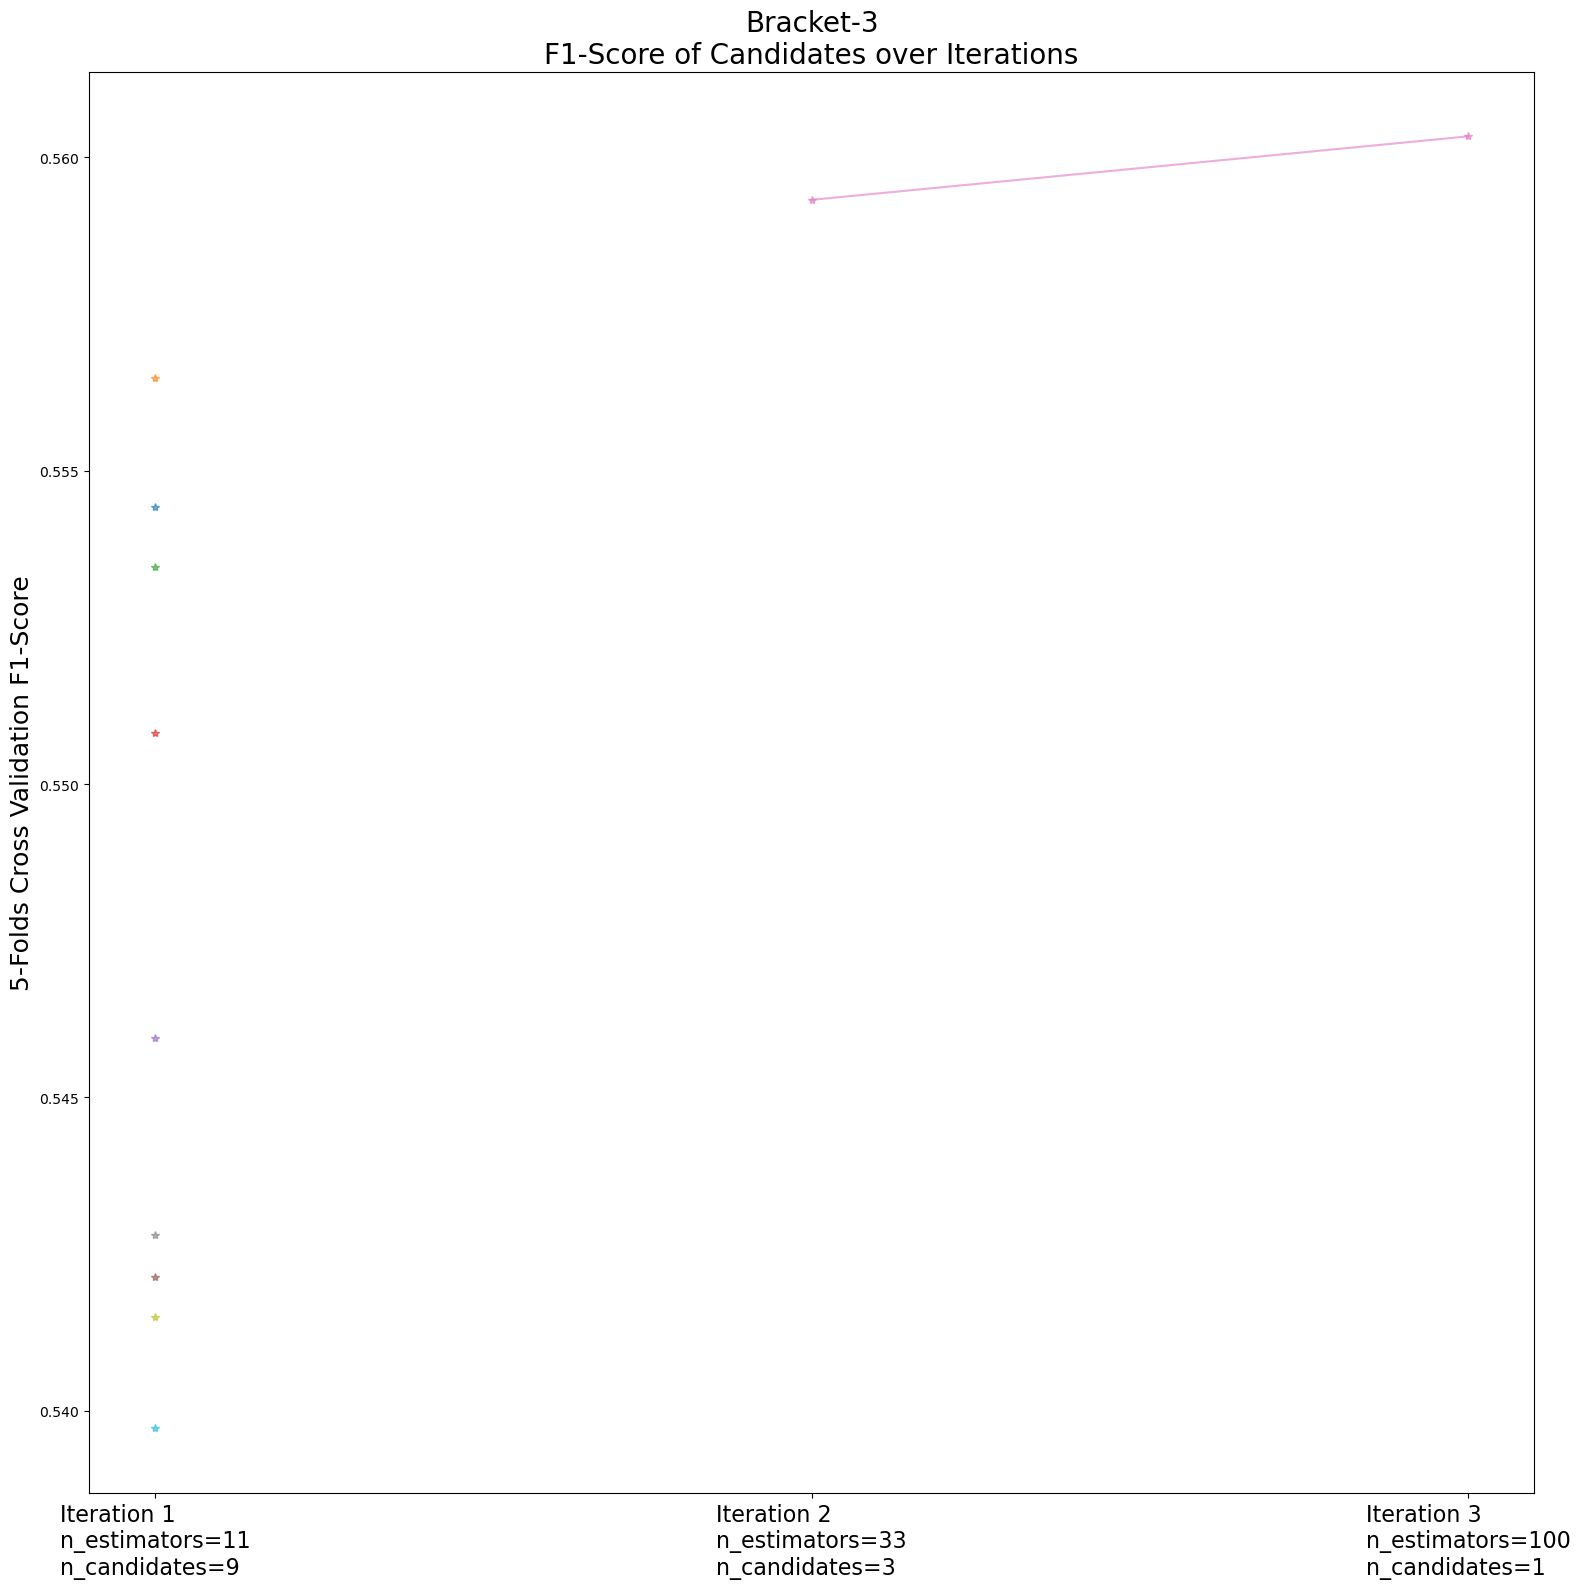

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.00556436446428297)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.0056342531345326165)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.006912383373655418)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.00705249304681055)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007243494302458289)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.007854418490576888)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005466182311285862)}"
SH_iter,,,,,,,
0,0.560062,0.557197,0.552496,0.552413,0.55409,0.54936,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.560336


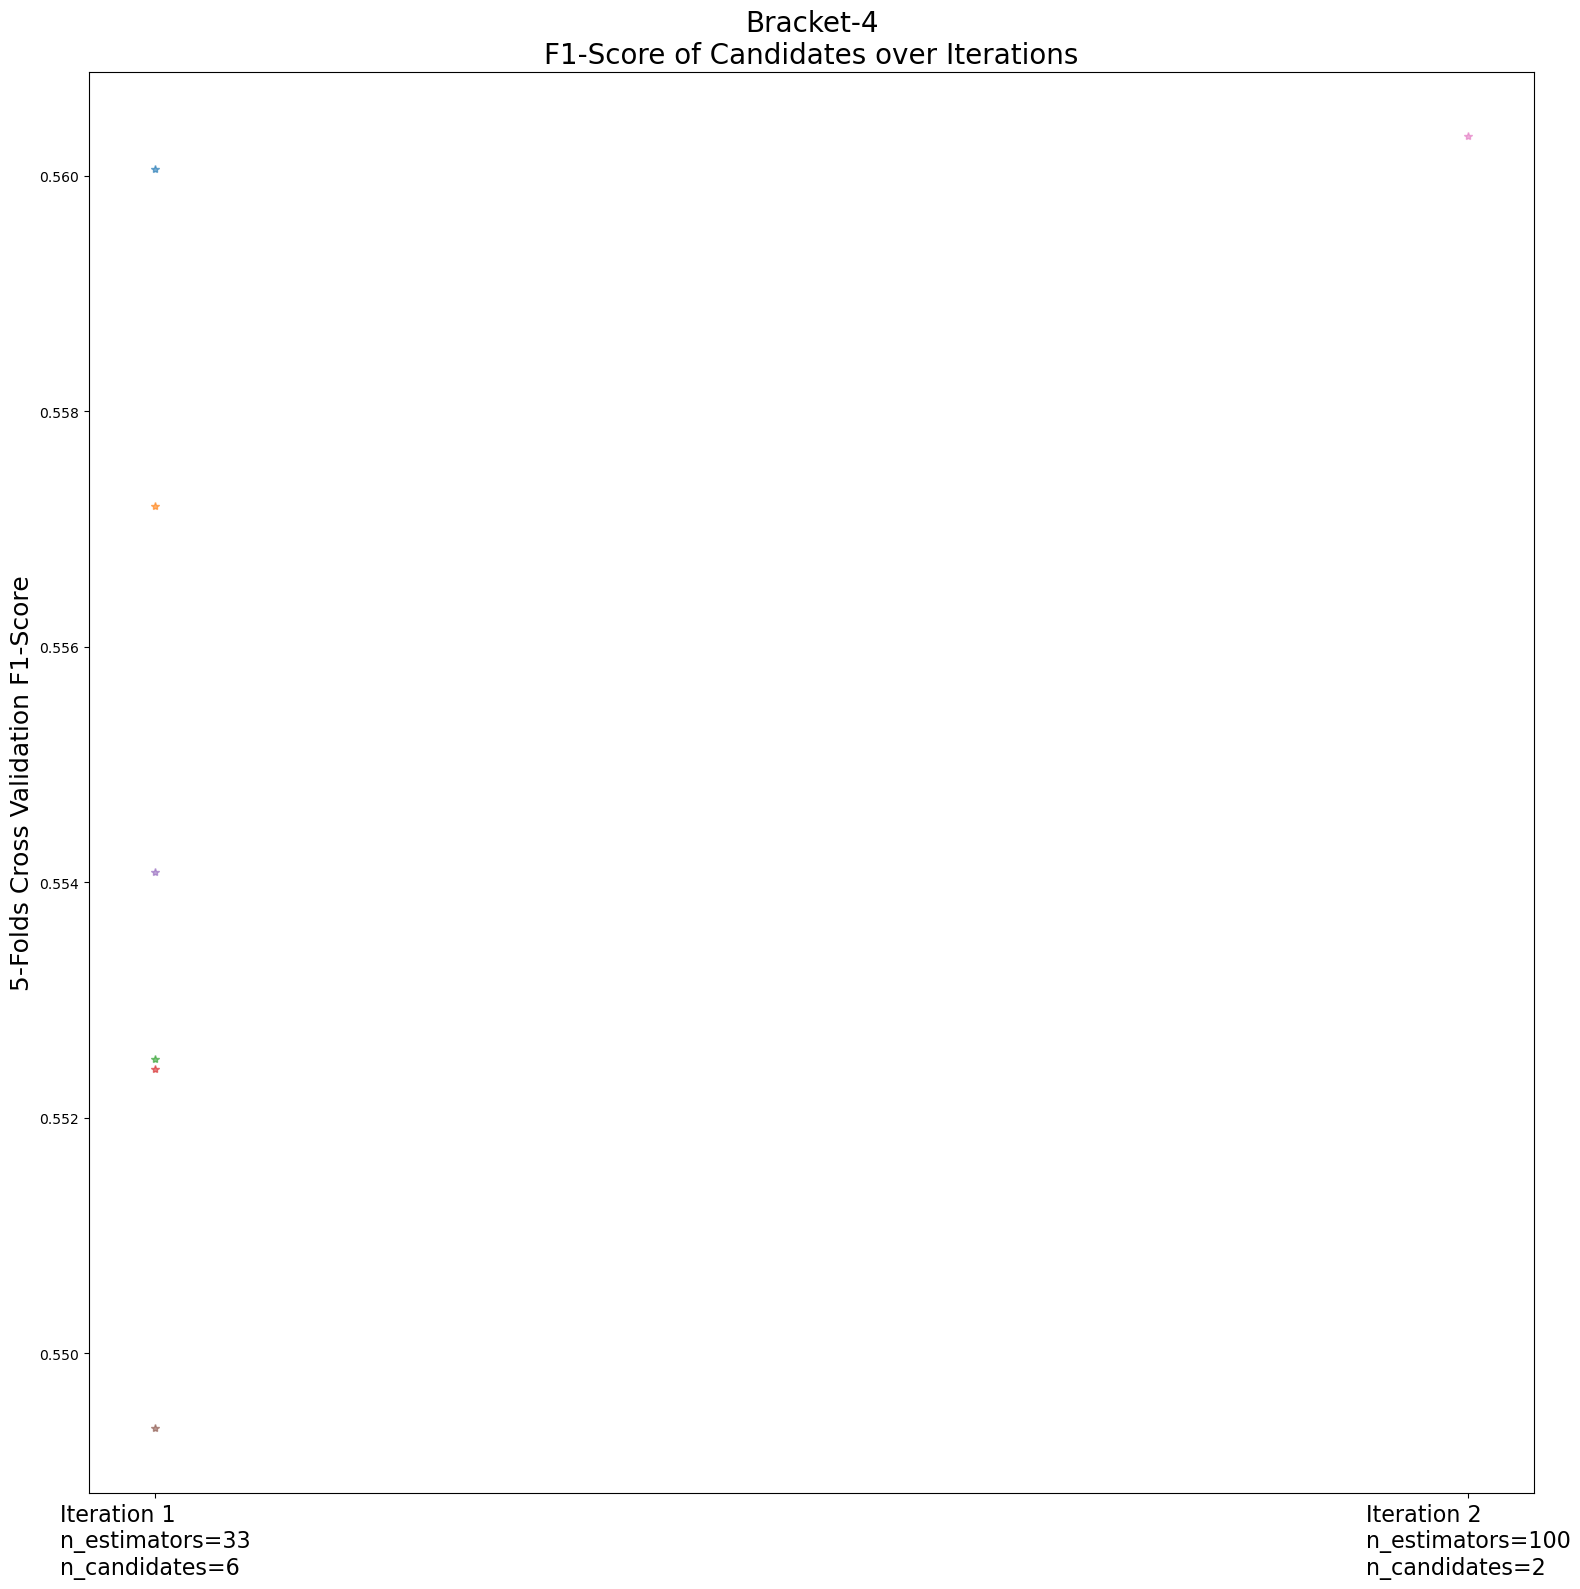

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.008674035266825923)}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005400472325183364)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': np.float64(0.00967859356432084)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.005880743499499386)}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': np.float64(0.007364144473535209)}"
SH_iter,,,,,
0,0.550288,0.557772,0.549562,0.556132,0.552696


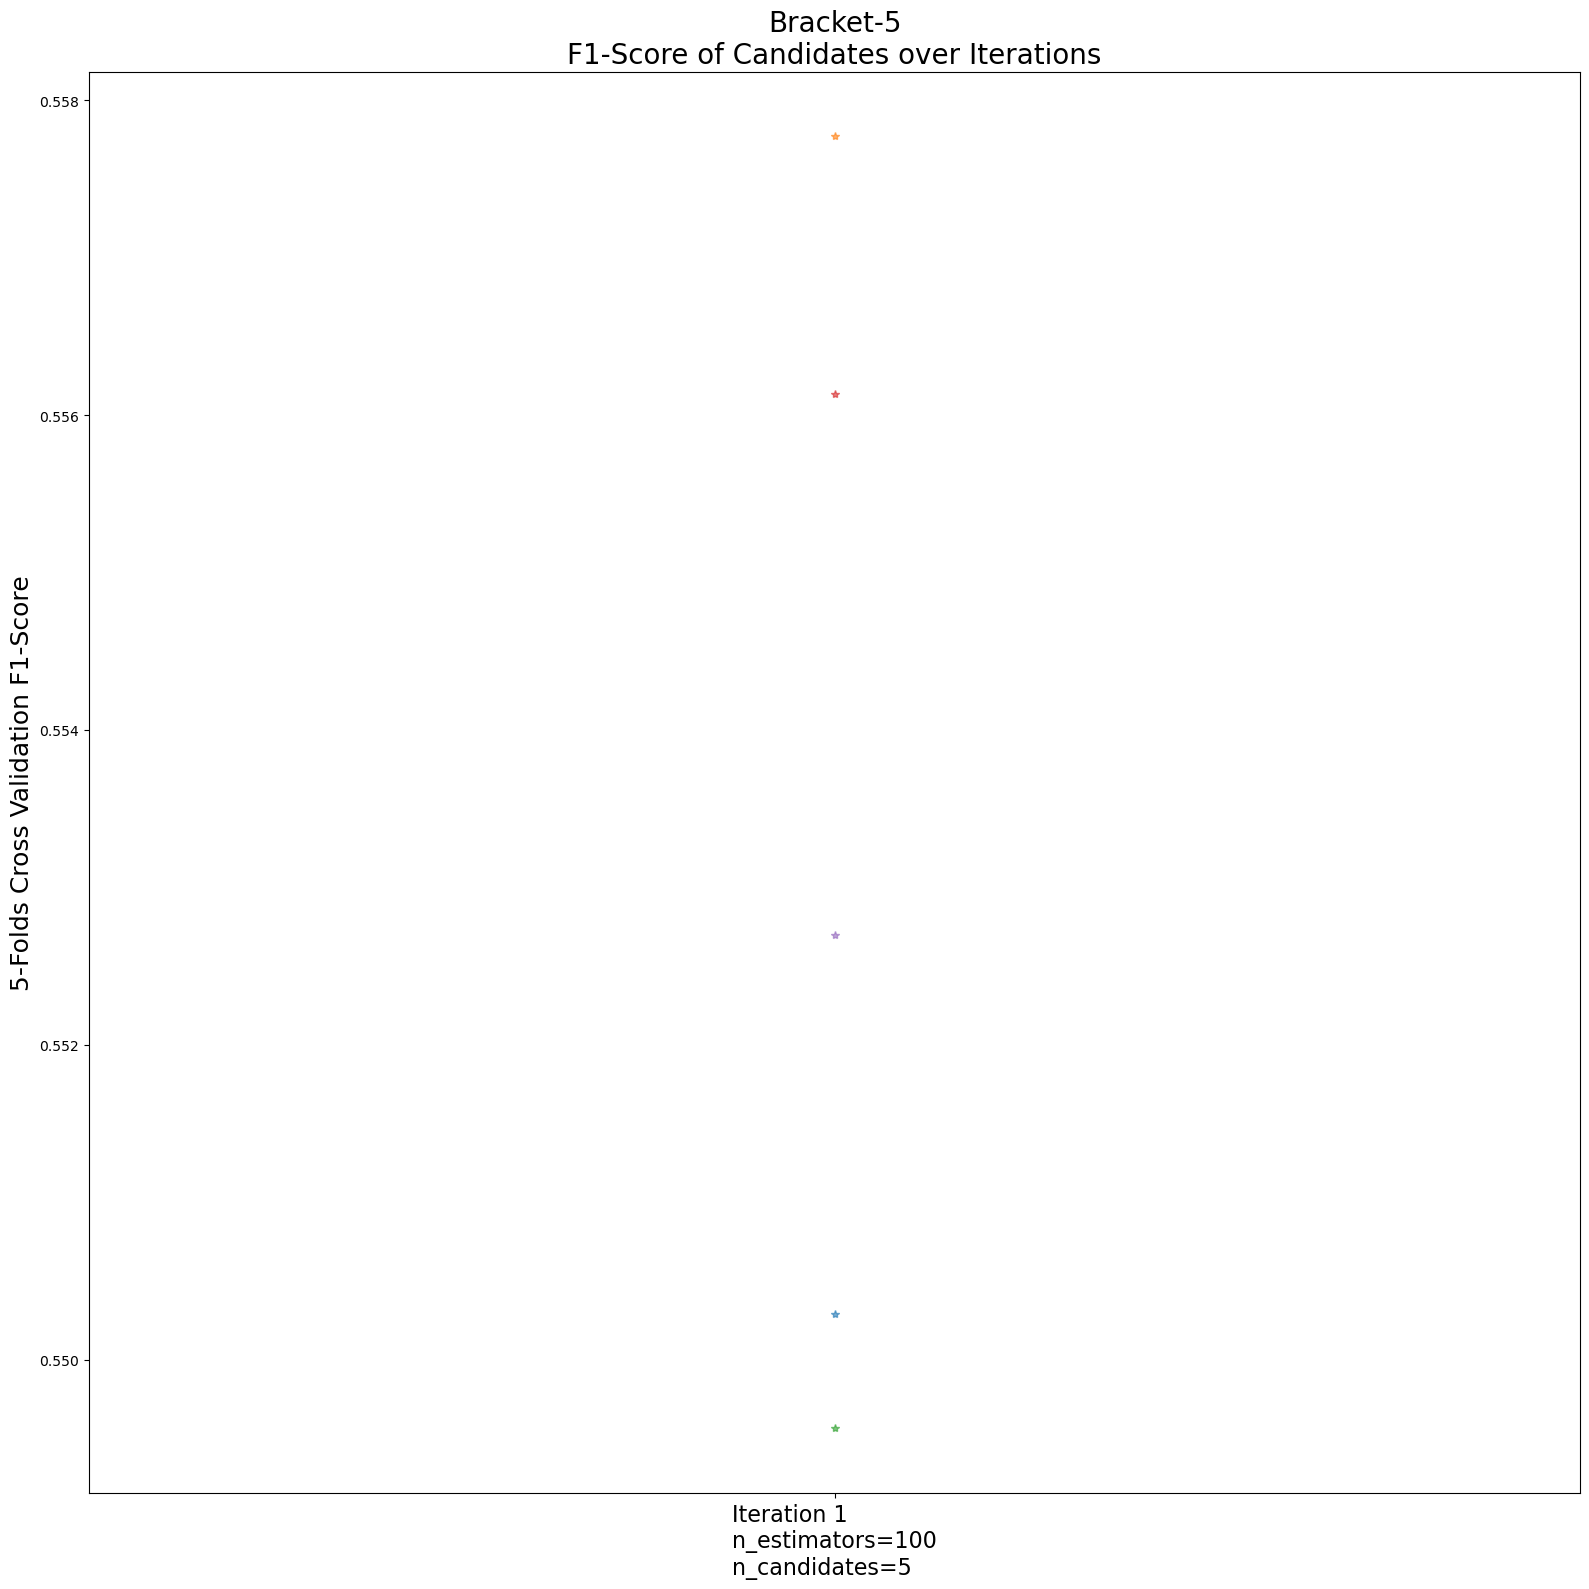

[CV] END model__class_weight=balanced, model__criterion=entropy, model__min_samples_split=0.008502698802829748, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced, model__criterion=entropy, model__min_samples_split=0.009419603574789047, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced, model__criterion=entropy, model__min_samples_split=0.007566189383136189, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced_subsample, model__criterion=gini, model__min_samples_split=0.005418277417274067, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced, model__criterion=entropy, model__min_samples_split=0.00893456605361023, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced, model__criterion=entropy, model__min_samples_split=0.008121082031977998, model__n_estimators=1; total time=   0.1s
[CV] END model__class_weight=balanced_subsample, model__criterion=gini

In [24]:
import warnings
warnings.filterwarnings('ignore')

for bracket_i, bracket in enumerate(results['hyperband_bracket'].unique()):
    results_SH = results[results['hyperband_bracket']==bracket]
    results_SH["params_str"] = results_SH.params.apply(str)
    results_SH.drop_duplicates(subset=("params_str", "SH_iter"), inplace=True)
    mean_scores = results_SH.pivot(
        index="SH_iter", columns="params_str", values="mean_test_score"
    )
    
    display(mean_scores)

    fig, ax = plt.subplots(figsize=(16,16))

    ax = mean_scores.plot(legend=False, alpha=0.6, marker="*",ax=ax)

    labels = [
        f"Iteration {i+1}\nn_estimators={clf.n_resources_[bracket_i][i]}\nn_candidates={int(clf.n_candidates_[bracket_i][i])}"
        for i in range(clf.n_trials_[bracket_i])
    ]

    ax.set_xticks(range(clf.n_trials_[bracket_i]))
    ax.set_xticklabels(labels, rotation=0, multialignment="left",size=16)
    ax.set_title(f"Bracket-{bracket_i+1}\nF1-Score of Candidates over Iterations",size=20)
    ax.set_ylabel("5-Folds Cross Validation F1-Score", fontsize=18)
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()